In [3]:
import pandas as pd 
import datetime
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [4]:
df = pd.read_csv('US Superstore data.csv',encoding='utf8')
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,08-11-16,11-11-16,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,08-11-16,11-11-16,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,12-06-16,16-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,11-10-15,18-10-15,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,11-10-15,18-10-15,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


In [5]:
print(df.isnull().sum())

Row ID           0
Order ID         0
Order Date       0
Ship Date        0
Ship Mode        0
Customer ID      0
Customer Name    0
Segment          0
Country          0
City             0
State            0
Postal Code      0
Region           0
Product ID       0
Category         0
Sub-Category     0
Product Name     0
Sales            0
Quantity         0
Discount         0
Profit           0
dtype: int64


In [6]:
df['Order Date'] = pd.to_datetime(df['Order Date'], format='%d-%m-%y')
max_invoice_dates = df.groupby('Customer ID')['Order Date'].max()
recency = (pd.to_datetime(max(max_invoice_dates)) - pd.to_datetime(max_invoice_dates)).dt.days 
frequency = df.groupby('Customer ID')['Order ID'].nunique() 
monetary_value = df.groupby('Customer ID')['Sales'].sum() 

In [7]:
rfm = pd.concat([recency, frequency, monetary_value], axis=1)
rfm.columns = ['Recency', 'Frequency', 'MonetaryValue']
rfm

,Recency,Frequency,MonetaryValue
Customer ID,,,
AA-10315,184,5,5563.560
AA-10375,19,9,1056.390
AA-10480,259,4,1790.512
AA-10645,55,6,5086.935
AB-10015,415,3,886.156
...,...,...,...
XP-21865,43,11,2374.658
YC-21895,4,5,5454.350
YS-21880,9,8,6720.444


In [8]:
scaler = StandardScaler()
rfm_std = scaler.fit_transform(rfm)

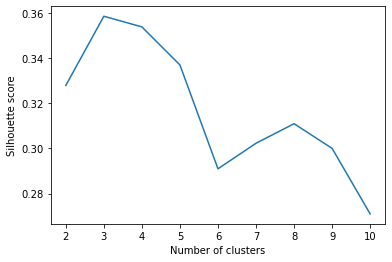

In [9]:
# Determine the optimal number of clusters
scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(rfm_std)
    score = silhouette_score(rfm_std, kmeans.labels_)
    scores.append(score)
plt.plot(range(2, 11), scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.show()

C:\Users\user\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


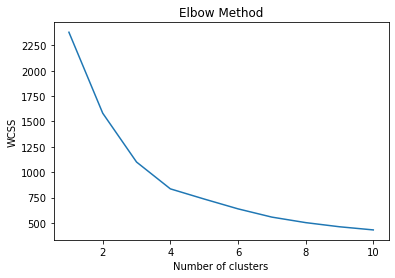

In [10]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(rfm_std)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()


In [11]:
# Fit K-means algorithm on RFM data
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(rfm_std)
labels = kmeans.predict(rfm_std)

# Assign segment labels to each customer
rfm['Segment'] = labels

In [12]:
# Calculate average RFM values for each segment
rfm[["Segment","Recency", "Frequency", "MonetaryValue"]].groupby("Segment").agg(["mean", "count","max"])


Recency             Frequency           MonetaryValue        \
               mean count   max      mean count max          mean count   
Segment                                                                   
0         87.651332   413   349  5.355932   413   9   1773.807449   413   
1        530.423423   111  1165  3.774775   111   9   1636.864907   111   
2         79.319703   269   410  8.840149   269  17   5140.990257   269   

                    
               max  
Segment             
0         6049.966  
1        10501.653  
2        25043.050

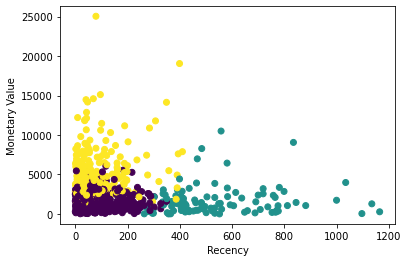

In [13]:
plt.scatter(rfm['Recency'], rfm['MonetaryValue'], c=rfm['Segment'])
plt.xlabel('Recency')
plt.ylabel('Monetary Value')
plt.show()

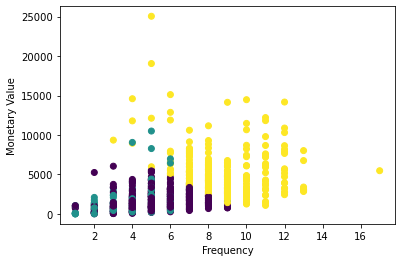

In [14]:
plt.scatter(rfm['Frequency'], rfm['MonetaryValue'], c=rfm['Segment'])
plt.xlabel('Frequency')
plt.ylabel('Monetary Value')
plt.show()

In [19]:
rfm.to_csv('rfm_segment.csv', index=True)